### Flower Species Identificatrion Model

The Flowers-102 dataset is a collection of 8,189 images covering 102 flower categories, each class representing a different species. The dataset is notably challenging due to its fine-grained nature, with some classes containing flowers that appear visually similar, making classification difficult. Each class varies in terms of the number of images, adding to the complexity due to potential class imbalances.

The goal of this project was to develop a deep learning model capable of accurately classifying images from the Flowers-102 dataset into their respective categories. By leveraging convolutional neural networks (CNNs) and techniques such as data augmentation and transfer learning, the aim was to create a model that could generalize well across the dataset, correctly identifying as many flower species as possible. The ultimate objective was to maximize the model's accuracy and evaluate its performance on unseen test data, analyzing strengths and areas for further improvement.

In [83]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Load the Flowers-102 dataset and split into training validation and test sets
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True, split=['train', 'validation', 'test'])
train_dataset, val_dataset, test_dataset = dataset


2024-08-15 14:15:46.625419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


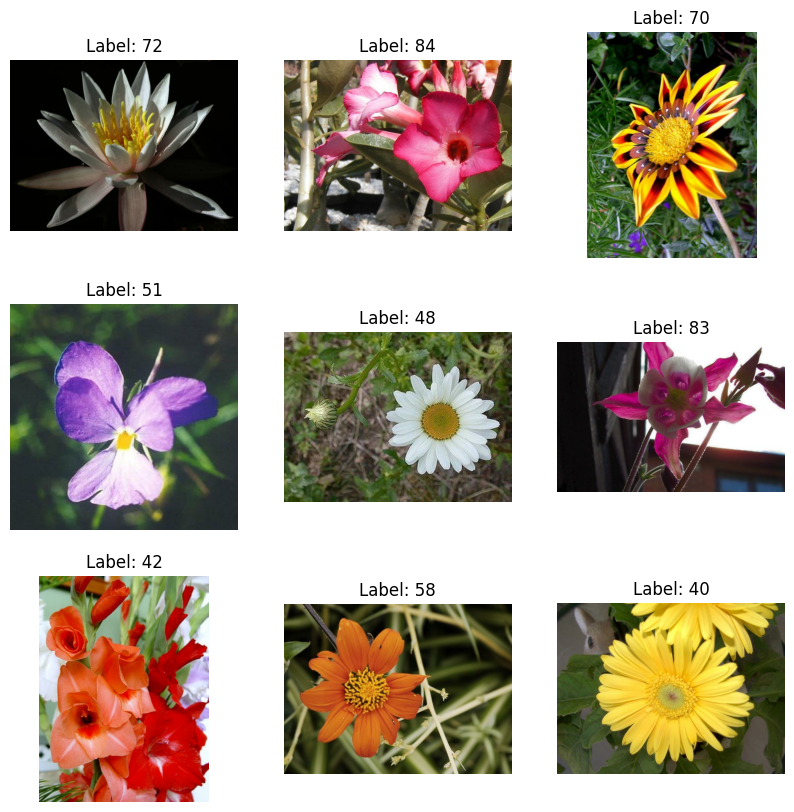

Dataset features: FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
})
Number of classes: 102
Dataset split sizes: {'train': <SplitInfo num_examples=1020, num_shards=1>, 'test': <SplitInfo num_examples=6149, num_shards=2>, 'validation': <SplitInfo num_examples=1020, num_shards=1>}
Example image shape: (None, None, 3)
Example label: ClassLabel(shape=(), dtype=int64, num_classes=102)
Image shape: (500, 667, 3)
Label: 72


2024-08-15 14:15:47.067968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [84]:
def visualize_data(dataset, num_examples=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_examples)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Label: {label.numpy()}")
        plt.axis('off')
    plt.show()

visualize_data(train_dataset)

print(f"Dataset features: {info.features}")
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Dataset split sizes: {info.splits}")
print(f"Example image shape: {info.features['image'].shape}")
print(f"Example label: {info.features['label']}")

for image, label in train_dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label.numpy()}")

Visualize class distribution

2024-08-15 14:15:50.546682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


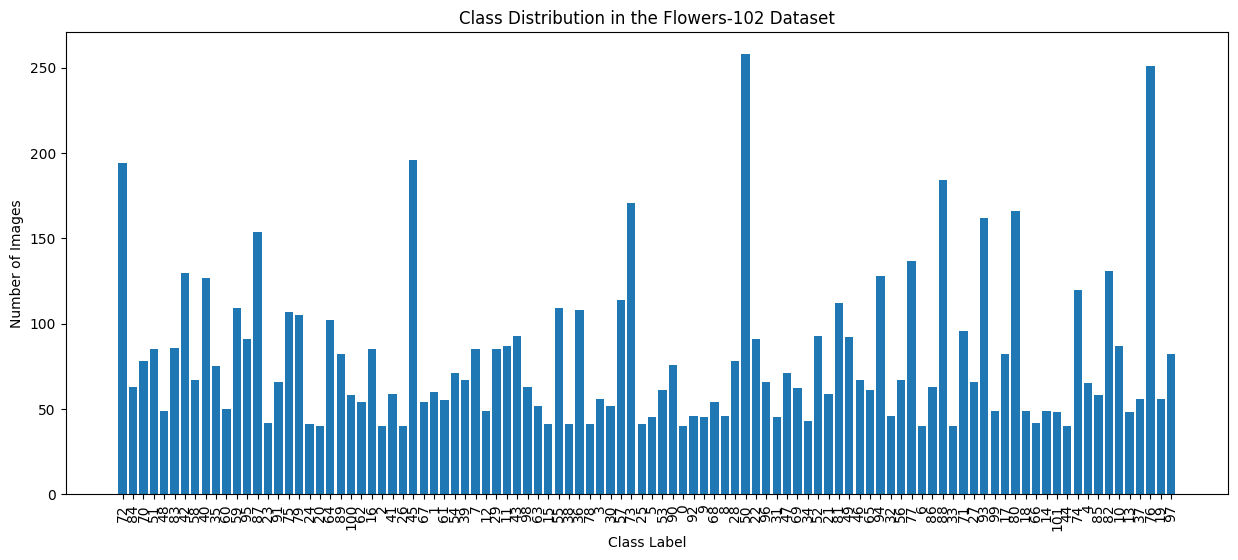

In [85]:
combined_dataset = train_dataset.concatenate(val_dataset).concatenate(test_dataset)

from collections import Counter

label_counts = Counter()
for _, label in combined_dataset:
    label_counts[label.numpy()] += 1

plt.figure(figsize=(15, 6))
plt.bar(range(len(label_counts)), label_counts.values(), tick_label=list(label_counts.keys()))
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Flowers-102 Dataset')
plt.xticks(rotation=90)
plt.show()


Inspect data

In [86]:
# 1. Explore Dataset Information
print("Dataset Info:")
print(info)

# 2. Inspect the Shape of Images
print("\nImage Shape Inspection:")
for image, label in train_dataset.take(5):  
    print(f"Image shape: {image.shape} | Label: {label.numpy()}")

# 3. Check the Range of Labels
all_labels = []
for _, label in combined_dataset:  
    all_labels.append(label.numpy())

print("\nLabel Range and Unique Labels:")
print(f"Minimum label value: {min(all_labels)}")
print(f"Maximum label value: {max(all_labels)}")
print(f"Unique labels: {set(all_labels)}")

# 4. Verify Data Types
print("\nData Types of Images and Labels:")
for image, label in train_dataset.take(1):
    print(f"Image data type: {image.dtype}")
    print(f"Label data type: {label.dtype}")

# 5. Check for Missing Data
print("\nCheck for Missing Data:")
print(f"Number of examples in the training set: {len(list(train_dataset))}")
print(f"Number of examples in the validation set: {len(list(val_dataset))}")
print(f"Number of examples in the test set: {len(list(test_dataset))}")


Dataset Info:
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/da

2024-08-15 14:15:50.883905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-15 14:15:53.946206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-15 14:15:53.976755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Label Range and Unique Labels:
Minimum label value: 0
Maximum label value: 101
Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}

Data Types of Images and Labels:
Image data type: <dtype: 'uint8'>
Label data type: <dtype: 'int64'>

Check for Missing Data:


2024-08-15 14:15:54.503467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of examples in the training set: 1020


2024-08-15 14:15:55.203498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of examples in the validation set: 1020


2024-08-15 14:15:59.128768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of examples in the test set: 6149


Model pre-processing, training, and testing

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0079 - loss: 5.3951 - val_accuracy: 0.0176 - val_loss: 4.8606 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0125 - loss: 4.9714 - val_accuracy: 0.0324 - val_loss: 4.8032 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0282 - loss: 4.8509 - val_accuracy: 0.0725 - val_loss: 4.7622 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0299 - loss: 4.7789 - val_accuracy: 0.0735 - val_loss: 4.7148 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0298 - loss: 4.7295 - val_accuracy: 0.1020 - val_loss: 4.6397 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0391 - loss: 4.6282 - val_accuracy: 0.1000 - val_loss: 4.5386 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0510 - loss: 4.5769 - val_acc

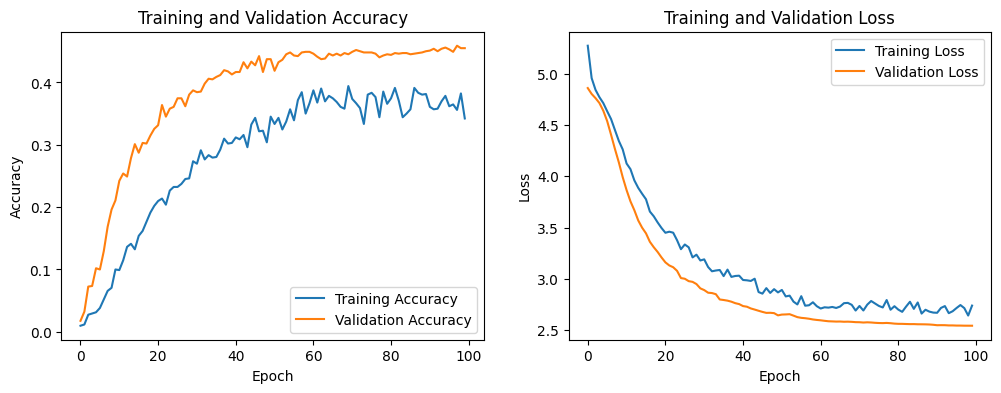

In [87]:
# Function to apply enhanced data augmentation using tf.image
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_jpeg_quality(image, 75, 100)
    return image, label

# Function to preprocess and augment the data
def preprocess_and_augment(image, label):
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    image, label = augment(image, label)  
    return image, label

# Function to preprocess the data without augmentation (for validation and test)
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Load the Flowers-102 dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True, split=['train', 'validation', 'test'])
train_dataset, val_dataset, test_dataset = dataset

# Apply preprocessing and augmentation to the training dataset
train_dataset = train_dataset.map(preprocess_and_augment).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Load a pre-trained VGG16 model and use it as a feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

# Build the new model using the pre-trained base
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),  
    Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
    Dropout(0.5),
    layers.Dense(info.features['label'].num_classes, activation='softmax')
])

# Compile the model with a learning rate scheduler
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Plotting the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [88]:
model.save('flower_classification_model.h5')

In [89]:
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y.numpy() for _, y in test_dataset])

print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(info.features['label'].num_classes)]))

def top_n_accuracy(y_true, y_pred, n=5):
    return np.mean([1 if y_true[i] in np.argsort(y_pred[i])[-n:] else 0 for i in range(len(y_true))])

top1_acc = top_n_accuracy(y_true, y_pred, n=1)
top5_acc = top_n_accuracy(y_true, y_pred, n=5)

print(f"Top-1 Accuracy: {top1_acc:.2f}")
print(f"Top-5 Accuracy: {top5_acc:.2f}")



193/193 ━━━━━━━━━━━━━━━━━━━━ 191s 986ms/step
              precision    recall  f1-score   support

           0       0.03      0.10      0.04        20
           1       0.59      0.90      0.71        40
           2       0.00      0.00      0.00        20
           3       0.21      0.17      0.18        36
           4       0.50      0.40      0.44        45
           5       0.30      0.36      0.33        25
           6       0.25      0.50      0.33        20
           7       0.72      0.83      0.77        65
           8       0.16      0.27      0.20        26
           9       0.58      1.00      0.74        25
          10       0.15      0.34      0.21        67
          11       0.76      0.58      0.66        67
          12       0.39      0.52      0.45        29
          13       0.70      0.68      0.69        28
          14       0.17      0.48      0.25        29
          15       0.31      0.38      0.34        21
          16       0.74      0.60   

2024-08-15 16:09:17.806700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


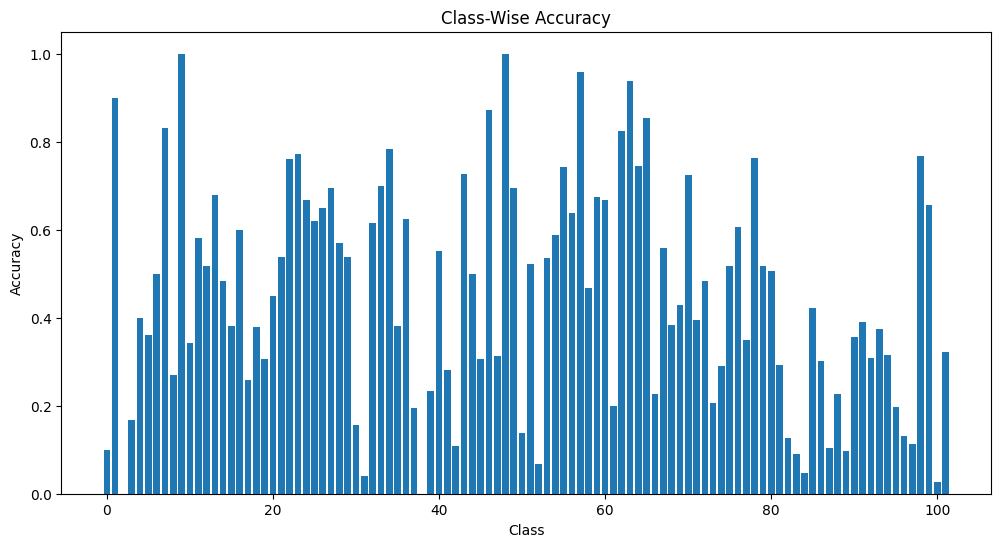

In [90]:
class_accuracies = []
for i in range(info.features['label'].num_classes):
    class_idx = np.where(y_true == i)
    class_acc = np.mean(y_pred_classes[class_idx] == y_true[class_idx])
    class_accuracies.append(class_acc)

plt.figure(figsize=(12, 6))
plt.bar(range(info.features['label'].num_classes), class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-Wise Accuracy')
plt.show()


2024-08-15 16:09:20.548837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


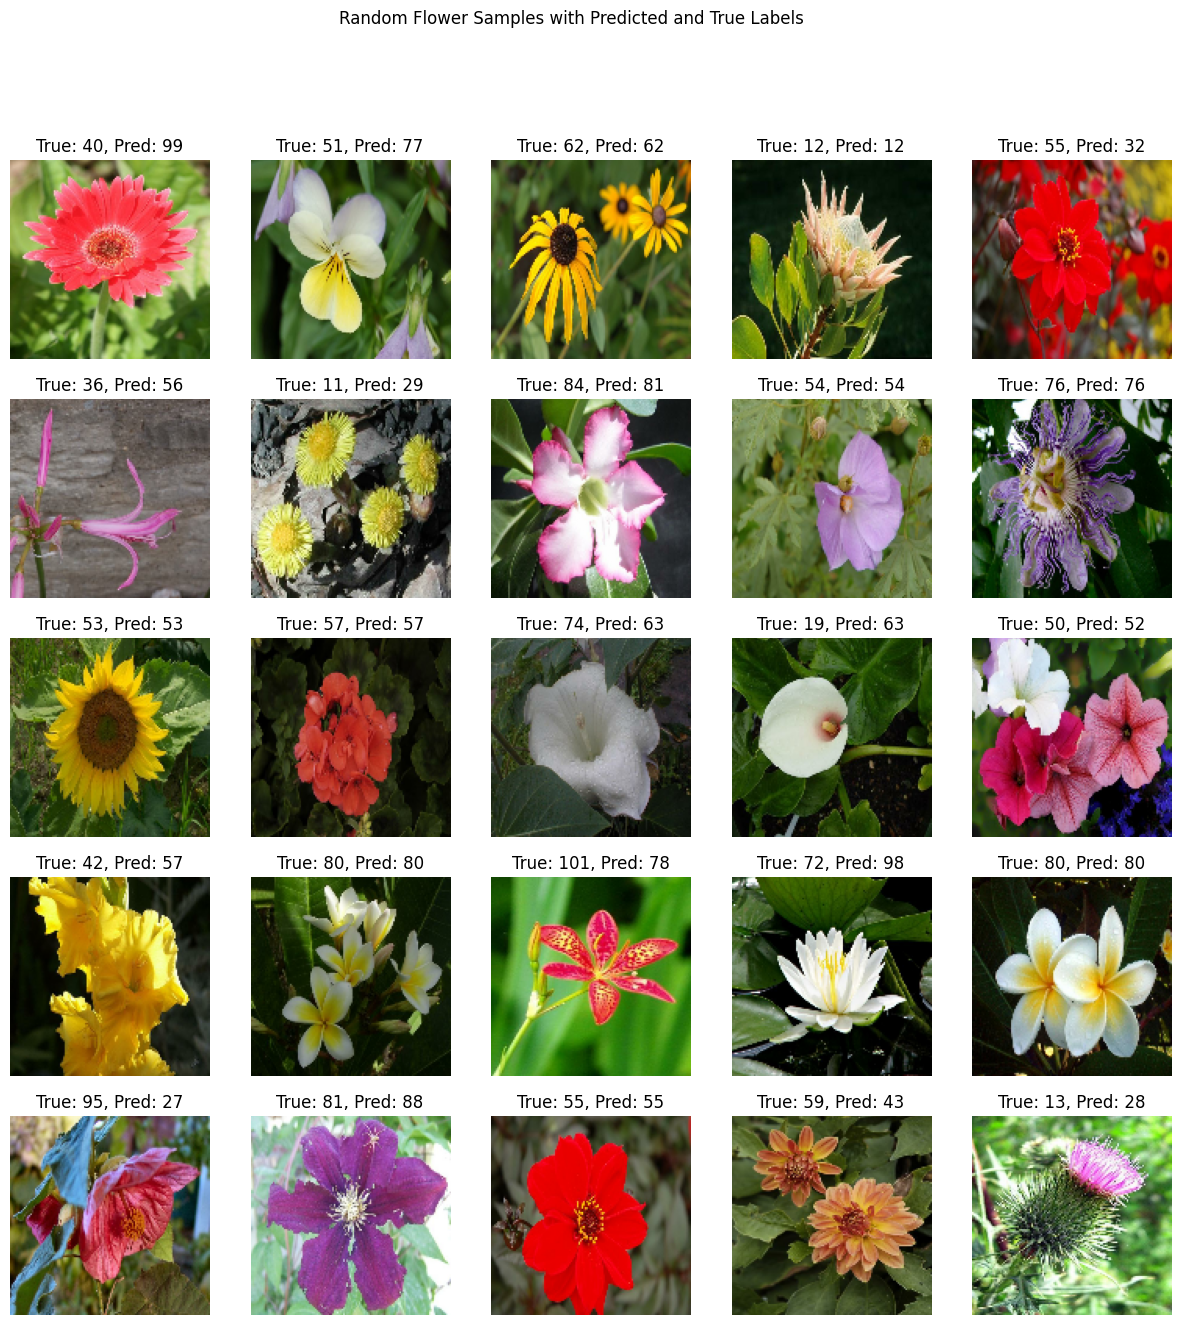

In [91]:
test_data = list(test_dataset.unbatch())

random_indices = np.random.choice(len(test_data), 25, replace=False)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img, true_label = test_data[idx]
    pred_label = y_pred_classes[idx]

    plt.subplot(5, 5, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"True: {true_label.numpy()}, Pred: {pred_label}")
    plt.axis('off')

plt.suptitle('Random Flower Samples with Predicted and True Labels')
plt.show()


Conclusion

The training and evaluation results indicate that while the model showed significant improvement over time, it still faces challenges in achieving high accuracy across all classes. The final test accuracy of 43% suggests that the model has learned some patterns but struggles with correctly identifying a majority of the classes. This is reflected in the precision, recall, and F1-scores, which vary widely among different classes, indicating inconsistent performance.

The model performed better on classes with more distinctive features or more training samples, as evidenced by higher recall scores in certain classes. However, for several classes, the precision and recall were low, indicating that the model is either overfitting to specific classes or failing to generalize well across the dataset.

The top-5 accuracy of 72% shows that when considering the top 5 predictions, the model is more likely to include the correct class, suggesting that it may be capturing some features relevant to the correct class but is not confident enough to rank them first.

Overall, while the model has made progress, further improvements are necessary. These could include fine-tuning the model architecture, increasing the complexity of data augmentation, or using techniques like transfer learning with a more powerful pre-trained model. Additionally, addressing class imbalances and refining hyperparameters could help improve the model's ability to generalize better across all classes.